In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from utils import rnmse
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Subset
from neuralop import FNO
import pandas as pd
import seaborn as sns
import matplotlib
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('hot', n_colors=7)
plt.rc('text', usetex=True)      

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

Error: trying to import DISCO convolutions without optional dependency torch-harmonics.  Please install with `pip install torch-harmonics` and retry.


In [2]:
x = torch.cat([torch.load("../dataset/x_train.pt"), torch.load("../dataset/x_train_2.pt")])
y = torch.cat([torch.load("../dataset/y_train.pt"), torch.load("../dataset/y_train_2.pt")])
c = torch.cat([torch.load("../dataset/c_train.pt"), torch.load("../dataset/c_train_2.pt")])

x_test = torch.load("../dataset/x_test.pt")
y_test = torch.load("../dataset/y_test.pt")
c_test = torch.load("../dataset/c_test.pt")

In [3]:
x.shape

torch.Size([27000, 256, 128])

In [4]:
x_np, y_np, c_np = x.numpy(), y.numpy(), c.numpy()
x_np_reshaped, y_np_reshaped, c_np_reshaped = x_np.reshape((x_np.shape[0], -1)), y_np.reshape((y_np.shape[0], -1)), c_np.reshape((c_np.shape[0], -1))
x_test_np, y_test_np, c_test_np = x_test.numpy(), y_test.numpy(), c_test.numpy()
x_test_np_reshaped, y_test_np_reshaped, c_test_np_reshaped = x_test_np.reshape((x_test_np.shape[0], -1)), y_test_np.reshape((y_test_np.shape[0], -1)), c_test_np.reshape((c_test_np.shape[0], -1))

In [5]:
x_np_reshaped = np.concatenate([x_np_reshaped, c_np_reshaped], axis=-1)
x_test_np_reshaped = np.concatenate([x_test_np_reshaped, c_test_np_reshaped], axis=-1)

In [6]:
y_np_reshaped.shape

(27000, 32768)

In [7]:
class DoNothingRegressor(BaseEstimator):
    def __init__(self):
        pass
    def fit(self, X, y):
        self.dim = y.shape[-1]
        pass
    def predict(self, X):
        return np.zeros(shape=(X.shape[0], self.dim))

In [8]:
class VanillaRegressor(BaseEstimator):
    def __init__(self, regressor, n_components=64):
        self.regressor = regressor
        self.n_components = n_components
        self.pipe = TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=self.n_components)),
                ("reg", self.regressor)
            ]),
            transformer=PCA(n_components=self.n_components),
            check_inverse=False
        )

    def fit(self, X, y):
        self.pipe.fit(X, y)

    def predict(self, X):
        return self.pipe.predict(X)

In [9]:
class ResidualRegressor(BaseEstimator):
    def __init__(self, regressor, n_components=64):
        self.n_components = n_components
        self.pipe_lm = TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=self.n_components)),
                ("lm", LinearRegression(n_jobs=-1))
            ]),
            transformer=PCA(n_components=self.n_components),
            check_inverse=False
        )
        self.regressor = regressor

    def fit(self, X, y):
        self.pipe_lm.fit(X, y)
        y_hat_lm = self.pipe_lm.predict(X)
        self.regressor.fit(X, y-y_hat_lm)

    def predict(self, X):
        return self.regressor.predict(X) + self.pipe_lm.predict(X)

In [10]:
def scorer_rnmse(estimator, x, y):
    return rnmse(estimator.predict(x), y)

In [11]:
n_points = 1024#x.shape[0]
n_cv = 5
n_components_pca = 8#512

In [12]:
scores = {}

In [13]:
scores["Residual PCR"] = cross_val_score(
    ResidualRegressor(DoNothingRegressor(), n_components_pca),
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse
)

In [14]:
scores["Vanilla LM"] = cross_val_score(
    VanillaRegressor(TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=n_components_pca)),
                ("lm", LinearRegression(n_jobs=-1))
            ]),
            transformer=PCA(n_components=n_components_pca),
            check_inverse=False
        ), n_components_pca),
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.7s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished


In [15]:
from sklearn.neighbors import KNeighborsRegressor
scores["Residual KNN"] = cross_val_score(
    ResidualRegressor(TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=n_components_pca)),
                ("knn", KNeighborsRegressor(10))
            ]),
            transformer=PCA(n_components=n_components_pca),
            check_inverse=False
        ), n_components_pca),
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


In [16]:
from sklearn.neighbors import KNeighborsRegressor
scores["Vanilla KNN"] = cross_val_score(
    VanillaRegressor(TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=n_components_pca)),
                ("knn", KNeighborsRegressor(10))
            ]),
            transformer=PCA(n_components=n_components_pca),
            check_inverse=False
        ), n_components_pca),
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


In [17]:
from sklearn.neural_network import MLPRegressor
scores["Residual MLP"] = cross_val_score(
    ResidualRegressor(TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=n_components_pca)),
                ("mlp", MLPRegressor(max_iter=1000))
            ]),
            transformer=PCA(n_components=n_components_pca),
            check_inverse=False
        ), n_components_pca),
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.3s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


In [18]:
from sklearn.neural_network import MLPRegressor

n_epochs = 1000

scores["Vanilla MLP"] = cross_val_score(
    VanillaRegressor(TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=n_components_pca)),
                ("mlp", MLPRegressor(max_iter=n_epochs))
            ]),
            transformer=PCA(n_components=n_components_pca),
            check_inverse=False
        ), n_components_pca),
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


In [19]:
from sklearn.ensemble import RandomForestRegressor
scores["Residual RF"] = cross_val_score(
    ResidualRegressor(TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=n_components_pca)),
                ("rf", RandomForestRegressor(n_jobs=-1))
            ]),
            transformer=PCA(n_components=n_components_pca),
            check_inverse=False
        ), n_components_pca),
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.2s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


In [20]:
from sklearn.ensemble import RandomForestRegressor
scores["Vanilla RF"] = cross_val_score(
    VanillaRegressor(TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=n_components_pca)),
                ("rf", RandomForestRegressor(n_jobs=-1))
            ]),
            transformer=PCA(n_components=n_components_pca),
            check_inverse=False
        ), n_components_pca),
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


In [21]:
class CNN(nn.Module):
    def __init__(self, input_dim=n_components_pca, output_dim=n_components_pca):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.head(self.features(x.unsqueeze(1)))

In [22]:
def get_rnmse():
    return rnmse

device = 'mps'

In [23]:
from skorch import NeuralNet

n_epochs = 500

pipe_cnn = TransformedTargetRegressor(
    regressor=Pipeline([
        ("pca", PCA(n_components=n_components_pca)),
        ("cnn", NeuralNet(
            CNN,
            max_epochs=n_epochs,
            criterion=get_rnmse,
            optimizer=optim.Adam,
            lr=1e-3,
            iterator_train__shuffle=False,
            device=device
        ))]),
    transformer=PCA(n_components=n_components_pca),
    check_inverse=False
)

scores["Vanilla CNN"] = cross_val_score(
    pipe_cnn,
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=n_cv,
    scoring=scorer_rnmse,
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0373        0.8790  0.5635
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0536        0.8842  0.5568
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9901        0.8816  0.8074
      2        0.8604        0.8524  0.0512
      2        0.8483        0.8640  0.0545
      2        0.8460        0.8531  0.0478
      3        0.8098        0.8325  0.0510
      3        0.8080        0.8451  0.0495
      3        0.8039        0.8361  0.0377
      4        0.7806        0.8347  0.0394
      4        0.7843        0.8256  0.0434
      4        0.7763        0.8184  0.0457
      5        0.7594        0.8217  0.0399
      5        0.7545        0.8370  0.0438
      5        0.7524        0.8114  0.0420
      6        0.7374        0.8199  0.0465
      6        0.7372        0.8

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.2s remaining:   31.8s


    481        0.0654        0.8979  0.0278
    483        0.0611        0.9457  0.0299
    481        0.0708        0.9009  0.0320
    482        0.0687        0.9098  0.0268
    484        0.0663        0.9605  0.0280
    482        0.0741        0.8966  0.0306
    483        0.0624        0.9051  0.0304
    485        0.0559        0.9578  0.0299
    483        0.0702        0.8961  0.0315
    484        0.0650        0.9017  0.0299
    486        0.0619        0.9469  0.0333
    484        0.0661        0.9061  0.0349
    485        0.0655        0.9115  0.0338
    487        0.0669        0.9632  0.0340
    485        0.0642        0.8950  0.0335
    486        0.0591        0.9051  0.0303
    488        0.0567        0.9525  0.0319
    486        0.0654        0.9005  0.0344
    487        0.0615        0.9028  0.0344
    489        0.0632        0.9491  0.0352
    487        0.0678        0.9035  0.0396
    488        0.0646        0.9160  0.0360
    490        0.0688        0.9

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.1s finished


In [24]:
data = pd.DataFrame(scores)[sorted(scores, key=lambda x: np.mean(scores[x]), reverse=True)]
data.to_csv('results_2.csv')
data

,Vanilla MLP,Residual MLP,Vanilla CNN,Residual PCR,Vanilla LM,Vanilla KNN,Vanilla RF,Residual KNN,Residual RF
0,0.736187,0.737153,0.686556,0.644447,0.644447,0.626437,0.628381,0.616478,0.615038
1,0.747617,0.727735,0.654227,0.631860,0.631860,0.613067,0.611977,0.607997,0.605873
2,0.736429,0.741522,0.693984,0.645631,0.645631,0.625630,0.614241,0.619878,0.613909
3,0.697338,0.705322,0.665596,0.633930,0.633930,0.610191,0.607216,0.606756,0.604326
4,0.698742,0.696649,0.647001,0.621279,0.621279,0.594946,0.591357,0.587779,0.588059


In [25]:
data_without_c = pd.read_csv('results.csv')
data["Residual MLP without c"] = data_without_c["Residual MLP"]

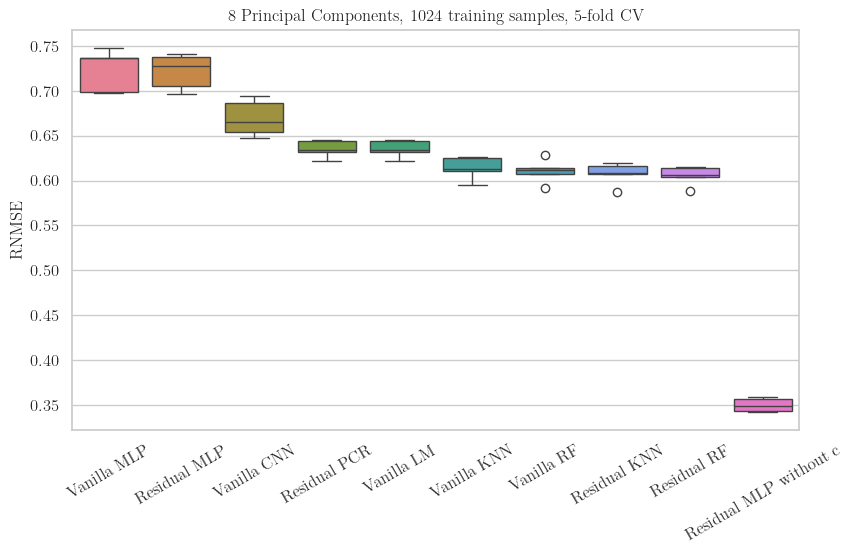

In [26]:
plt.figure(figsize=(9, 6))
plt.title(f"{n_components_pca} Principal Components, {n_points} training samples, {n_cv}-fold CV")
sns.boxplot(data)
plt.ylabel("RNMSE")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('results_2.jpg', dpi=150)
plt.show()